# Quarterly SPY Monte Carlo Analysis

### Problem
You are a smart retail investor. You've made some solid plays here and there and have a strong consistent portfolio. You and your coworkers all talk finance stuff at the Keurig machine on your sweet middle management floor. Your new intern has no real knowledge in investing. Your intern comes up one day and asks you how high SPY might climb this quarter. "SPY 300," you say. How low could it go? SPY 230. How confident? Very. Percentage? 95% How do you know? Seriously, how do you know?
    
You really don't, and neither do I. However, you and me together can get a rough idea with some neat statistics and inefficient code.

### Monte Carlo Method and Simulation

This is kind of a buzzword in the data science world because it sounds and looks complicated. Since computers can do all the heavy lifting for us, it really is not. The Monte Carlo method was first thought of by Stanislaw Ulam, who worked on the Manhattan Project (Wikipedia). Conceptually, the Monte Carlo method is an algorithm that computes the odds of an outcome in a complex environment through random iterations of it. The example Stanislaw used was solitaire. The odds of winning a solitaire game is hard to compute. There's very little information and a lot of plays between the start and end of the game. The only real way to find the odds of winning any game of solitaire is to just play an infinite amount of games and record every outcome. Then the probability of winning would just be wins divided by games. Mathematically it is represented as $$E(X) \approx  \frac{1}{N} \sum_{n=1}^{N} x_n $$

### Two More Pieces to the Pie

That equation is pretty and all but it's missing a huge part which is the randomness. Securities move randomly and can be modeled with a form of a random walk called Brownian Motion. For this simulation, a random walk is rigorous  enough. This is the first piece to this pie.

#### Random Walk

A random walk occurs when the movement of an object follows no discernable trend or pattern. In financial markets, this is true to a point, researchers and economists debate how well a random walk holds over different periods of time but for a time period as short as one quarter, I think it holds.

#### Central Limit Theorem

The central limit theorem is the last piece to this pie and I would argue is the biggest star. It posits that if a large number  of random samples are taken, then the distribution will tend to be normal. Normal distributions let us then find the probability that something will happen by finding the area under the normal distribution curve. So, if we take enough random samples, we will have this nice bell shaped curve and the area underneath the curve from between two points is the probability that an outcome will happen.

### Putting It All Together

Applying this idea of randomness, we can now create a new equation, one specifically to model this random walk, then we compute it over 5000 times over 3 months of trading days. Then we plot the histogram, find the z-scores of the last day, plot them and state our confidence.

The price of a stock in the current time period, day, should be equal to the last price multiplied by the periodic daily return. 

$$ S_t = S_{t-1} \times e^r $$

Where S is price, t is time period, e is the mathematical constant of base log, and r is the periodic daily return. The periodic daily return is where the random walk comes into play. We will generate a large number of random periodic daily returns that are drawn from random samples of a normal distributions using a standard deviation of the percentage change in closing price of each day. In human words, the daily return in this simulation will be found by picking numbers at random that when multiplied with the price will form that bell curve we want.

### Walkthrough

Here we import all the needed libraries, as well as access the file with SPY prices for the last 5 years.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import os
path = "C:\\\\Users\\\AnthonyS/DS Stuff/Mathematical Foundation Notebooks/SPY Monte Carlo"
train = pd.read_csv(path + "/SPY.csv")
%matplotlib inline
style.use('ggplot')

In this next block, we compute the percent change of closing prices and assign them to a new column. Then we specify the number of simulations we want to run, number of days to plot, and create a variable to store the last price.

In [2]:
train['returns'] = train['Close'].pct_change()
num_sims = 7500
num_days = 63
simulation_df = pd.DataFrame() 
last_price = train['Close'].iloc[-1]

Here is the real **meat** of the simulation. We write a for loop that loops through the desired simulation number, then a nested for loop for the amount of days. We assign daily_vol to equal the standard deviation of our percent daily returns. Then we have this numpy method called random.normal. This method is what randomly picks those daily returns that when multiplied by our price will create this nice bell shaped curve. The rest of the for loop just populates an array that gets appended to a DataFrame for each simulation.

In [3]:
for x in range(num_sims):
    count = 0
    daily_vol = train['returns'].std()
    
    price_series = []
    
    price = last_price * (1 + np.random.normal(0, daily_vol))
    price_series.append(price)
    
    for y in range(num_days):
        if count == 63:
            break 
        price = price_series[count] * (1 + np.random.normal(0, daily_vol))
        price_series.append(price)
        count +=1
    
    simulation_df[x] = price_series

Now we plot all the simulations and take a look.

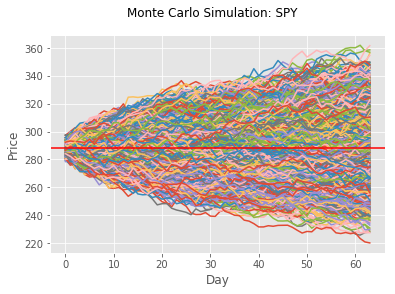

In [4]:
fig = plt.figure()
fig.suptitle('Monte Carlo Simulation: SPY')
plt.plot(simulation_df)
plt.axhline(y = last_price, color = 'r', linestyle = '-')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

This is quite the range. SPY 360 confirmed. The next steps we have to do is create a histogram to see if our simulations were actually normal distributed. Histograms are those graphs that are vertical barcharts and form that bell shape. But how wide should a one of the bars be? Luckily for you and me, a couple incredibly smart people created a formula to find them. It's called the Freedman-Diaconis rule and it's pretty simple. All we do is find the interquartile range then divide it by the cube root of the number of simulations and multiply the whole thing by two.

In [5]:
# Creating histogram plot. Using Freedman-Diaconis rule for optimal width of bins
# 1. Find Inter-quartile range, by takin the upper and lower median after finding the real median, then subtracting the two numbers
# Pandas has quartile support already built in.
quantile_df = pd.DataFrame
quantile_df = simulation_df.quantile([0.25, 0.5, 0.75], axis = 1)
#This computed the 1st quartile, median, and third quartile for all projected days

In [6]:
quantile_df.loc['IQR'] = quantile_df.loc[0.75] - quantile_df.loc[0.25] 
#This is now the IQR

In [7]:
#2. Calcualte the size of the bins using Freedman-Diaconis
bin_width = pd.DataFrame
bin_width = 2 * (quantile_df.loc['IQR'] / np.cbrt(num_sims))

In [8]:
bin_width.head()

0    0.374857
1    0.553560
2    0.659112
3    0.778114
4    0.873584
Name: IQR, dtype: float64

Funny enough we did all this work just for matplotlib to already have an automatic way to calculate it but its important to know.

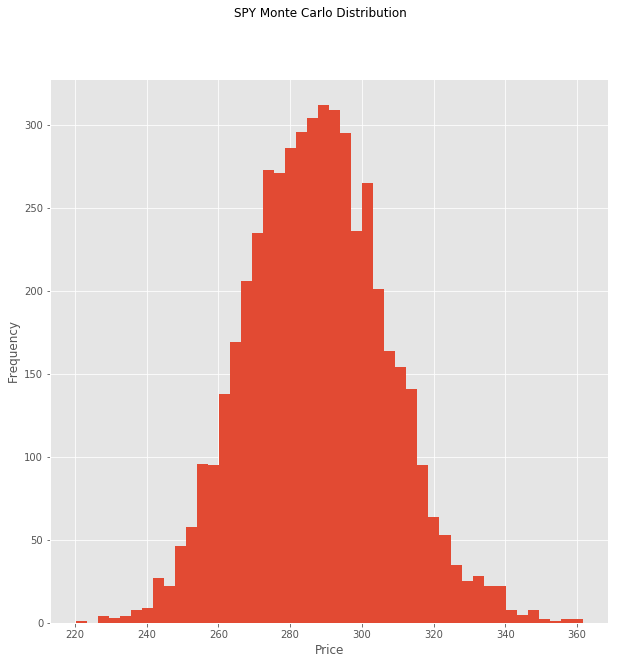

In [9]:
#Plot histogram
fig = plt.figure(figsize = (10, 10))
fig.suptitle("SPY Monte Carlo Distribution")
plt.hist(simulation_df.iloc[-1], bins = 'fd')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

This is a pretty good normal distribution.

In [39]:
#Now that we have confirmed that the days follow a somewhat normal distribution
#Find 75, 90% confidence interval across all days
#First we need to flip the entire simulation table
flip_table = simulation_df.transpose()

In [41]:
#Now we calculate the zscore for that each simulation on the last day
flip_table['zscore'] = (flip_table.iloc[:, -1] - flip_table.iloc[:, -1].mean())/ flip_table.iloc[:, -1].std(ddof = 0)

In [42]:
#Copy dataframe so we can cut values that do not have a zscore in the range of our purposes
last_df = pd.DataFrame
last_df = flip_table

In [43]:
#90% interval is all z_scores between -1.645 and 1.645
last_df = last_df[(last_df.iloc[:, -1] < 1.645) & (last_df.iloc[:, -1] > -1.645)]

In [44]:
plot_df = last_df.transpose()

In [46]:
plot_df.drop(plot_df.tail(1).index,inplace=True)

In [47]:
forecast_max = plot_df.iloc[-1].max()
forecast_min = plot_df.iloc[-1].min()
forecast_max = np.round(forecast_max, 2)
forecast_min = np.round(forecast_min, 2)

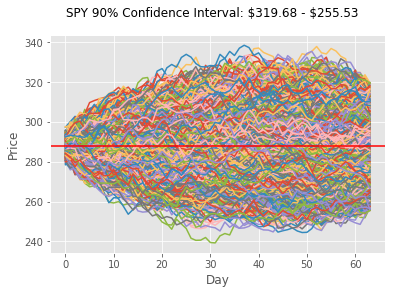

In [48]:
fig = plt.figure()
fig.suptitle('SPY 90% Confidence Interval: \$' + np.str(forecast_max) + " - \$" + np.str(forecast_min))
plt.plot(plot_df)
plt.axhline(y = last_price, color = 'r', linestyle = '-')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

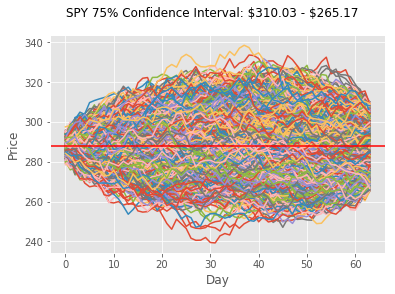

In [49]:
last_df = flip_table
#75% Confidence interval is all z_scores between -1.15 adn 1.15
last_df = last_df[(last_df.iloc[:, -1] < 1.15) & (last_df.iloc[:, -1] > -1.15)]
plot_df = last_df.transpose()
plot_df.drop(plot_df.tail(1).index,inplace=True)
forecast_max = plot_df.iloc[-1].max()
forecast_min = plot_df.iloc[-1].min()
forecast_max = np.round(forecast_max, 2)
forecast_min = np.round(forecast_min, 2)
fig = plt.figure()
fig.suptitle('SPY 75% Confidence Interval: \$' + np.str(forecast_max) + " - \$" + np.str(forecast_min))
plt.plot(plot_df)
plt.axhline(y = last_price, color = 'r', linestyle = '-')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

### Conclusions

This is a pretty amazing feat we just accomplished. We put a percent chance of the range SPY will end in, in the next three months. We have taken this abstract idea of how confident you are in your SPY range and gave it numerical value with mathematical foundation. Using three different math and statistics ideas, we combined them in a seamless manner that makes sense in normal language. Now you can boast to your other middle management coworkers about your new "range" and how excited you are about it. 